<a href="https://colab.research.google.com/github/Dhruv-Ganapati/Emotion_Detection_usingAI/blob/main/Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Header: Emotion Detection:

### Libraries

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
%cd /content/drive/MyDrive/Colab Notebooks/AI-Udemy/Bonus Projects/Affectiva AI

/content/drive/MyDrive/Colab Notebooks/AI-Udemy/Bonus Projects/Affectiva AI


In [107]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers

from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [108]:
df = pd.read_csv('data.csv')

In [109]:
df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,...,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,...,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,...,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,...,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [110]:
df.head(5)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [111]:
df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [113]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
left_eye_center_x,2140.0,66.221549,2.087683,47.835757,65.046300,66.129065,67.332093,78.013082
left_eye_center_y,2140.0,36.842274,2.294027,23.832996,35.468842,36.913319,38.286438,46.132421
right_eye_center_x,2140.0,29.640269,2.051575,18.922611,28.472224,29.655440,30.858673,42.495172
right_eye_center_y,2140.0,37.063815,2.234334,24.773072,35.818377,37.048085,38.333884,45.980981
left_eye_inner_corner_x,2140.0,59.272128,2.005631,41.779381,58.113054,59.327154,60.521492,69.023030
left_eye_inner_corner_y,2140.0,37.856014,2.034500,27.190098,36.607950,37.845220,39.195431,47.190316
left_eye_outer_corner_x,2140.0,73.412473,2.701639,52.947144,71.741978,73.240045,74.978684,87.032252
left_eye_outer_corner_y,2140.0,37.640110,2.684162,26.250023,36.102409,37.624207,39.308331,49.653825
right_eye_inner_corner_x,2140.0,36.603107,1.822784,24.112624,35.495730,36.620735,37.665280,47.293746
right_eye_inner_corner_y,2140.0,37.920852,2.009505,26.250023,36.766783,37.920336,39.143921,44.887301


Here, 30 columns are Floating type data set and Remaining 1 data set is image(Object type).

Images contains values of it's color.
* 0 : represent full balck object
* 255: represent white image object
* Between 0-255: represent Gray-scale image.

In [114]:
df['Image']

0       238 236 237 238 240 240 239 241 241 243 240 23...
1       219 215 204 196 204 211 212 200 180 168 178 19...
2       144 142 159 180 188 188 184 180 167 132 84 59 ...
3       193 192 193 194 194 194 193 192 168 111 50 12 ...
4       147 148 160 196 215 214 216 217 219 220 206 18...
                              ...                        
2135    191 191 191 190 189 185 184 120 54 34 19 24 31...
2136    19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137    31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138    7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...
2139    68 19 19 23 19 26 23 16 8 15 9 9 17 16 15 27 2...
Name: Image, Length: 2140, dtype: object

In [115]:
df['Image'].shape

(2140,)

In [116]:
df['Image'].size

2140

In [117]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep=' ').reshape(96,96))

In [118]:
df['Image'][0].shape

(96, 96)

MINI CHALLENGE #1:
- Obtain the average, minimum and maximum values for 'right_eye_center_x'

In [119]:
df['right_eye_center_x'].describe()

count    2140.000000
mean       29.640269
std         2.051575
min        18.922611
25%        28.472224
50%        29.655440
75%        30.858673
max        42.495172
Name: right_eye_center_x, dtype: float64

### ==========================================================

# PERFORM IMAGE VISUALIZATION

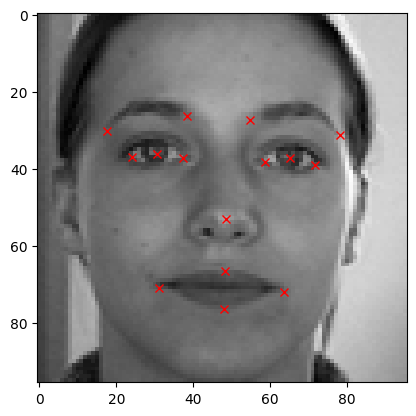

In [120]:
# Plot a random image from the dataset along with facial keypoints.
# Image data is obtained from df['Image'] and plotted using plt.imshow
# 15 x and y coordinates for the corresponding image
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.

np.random.seed(78)    # For same image, seed helps to provide same  random value everytime
i = np.random.randint(1, len(df))
plt.imshow(df['Image'][i], cmap='gray')
for j in range(1,31,2):
  plt.plot(df.loc[i][j-1], df.loc[i][j], 'rx')

* <!-- i =[]
for j in range(1, 31, 2):
  i.append(j)
  print(i) -->

I:  [1943, 40, 541, 78, 2091, 708, 148, 1110, 1638, 1015, 1027, 1062, 1497, 578, 1613, 1182]


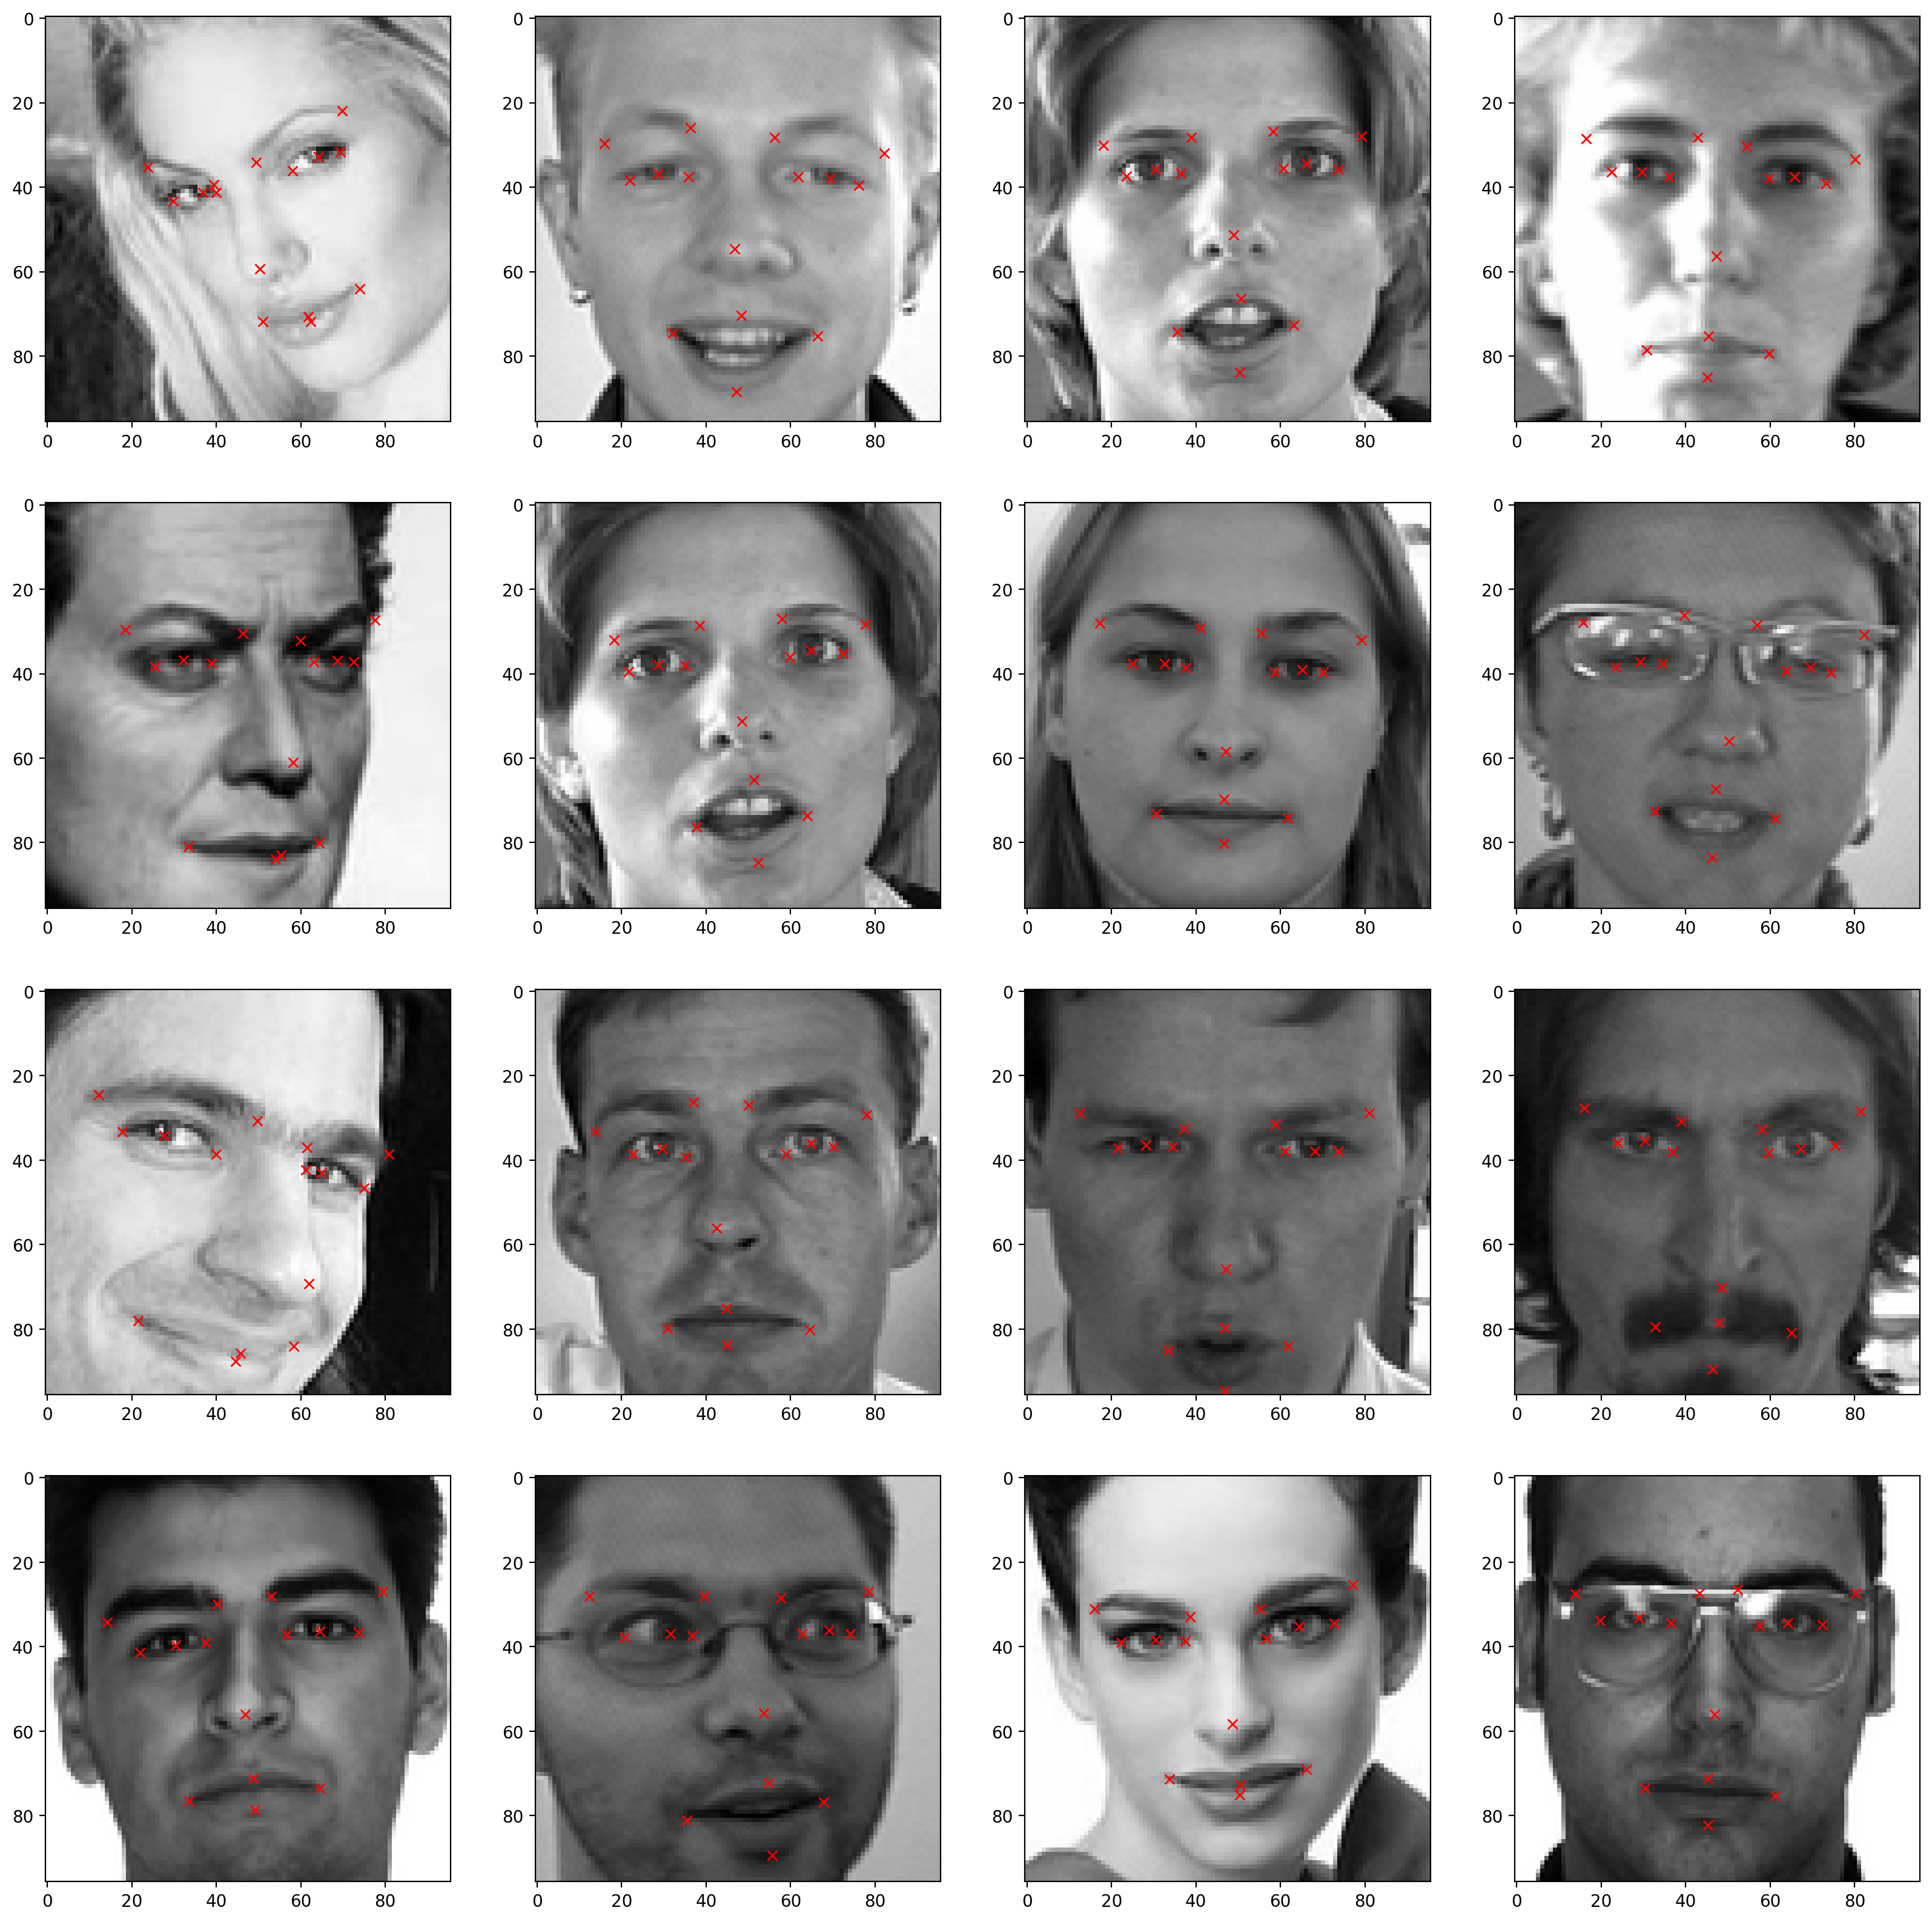

In [121]:
#View more images in grid format
fig = plt.figure(figsize=(20,20),dpi=200)

i=[]
# for m in range(16):
#   i.append(np.random.randint(m,len(df)))    # Generate random images and stores on I[] list

# Generate 16 unique random numbers
while len(i) < 16:
    random_number = np.random.randint(0, len(df))  # Generate a random number
    if random_number not in i:   # Check if the number is unique
        i.append(random_number)  # Append unique random number
print("I: ", i)

for a in range(16):
  ax = fig.add_subplot(4,4,a+1)           # provide 16 empty image boxes
  a = i[a]                        # Putting random images loc on loop
  image = plt.imshow(df["Image"][a], cmap='gray')   # FIll all the related images on the boxes
  for j in range(1, 31, 2):
    plt.plot(df.loc[a][j-1], df.loc[a][j], 'rx')     # Fill the red 'x' facial point.


MINI CHALLENGE #2:
- Perform a sanity check on the data by randomly visualizing 64 new images along with their cooresponding key points

[163, 101, 2005, 322, 340, 1629, 2124, 1206, 1928, 276, 2108, 1505, 1900, 352, 1321, 895, 1598, 1382, 422, 1190, 1166, 1690, 909, 665, 1964, 1292, 2004, 1108, 1726, 2120, 179, 482, 81, 109, 1515, 1674, 467, 1342, 1974, 23, 643, 1365, 122, 762, 2039, 1938, 492, 1424, 989, 1806, 677, 1534, 1097, 1022, 465, 549, 1911, 250, 578, 1817, 1251, 319, 1925, 874]


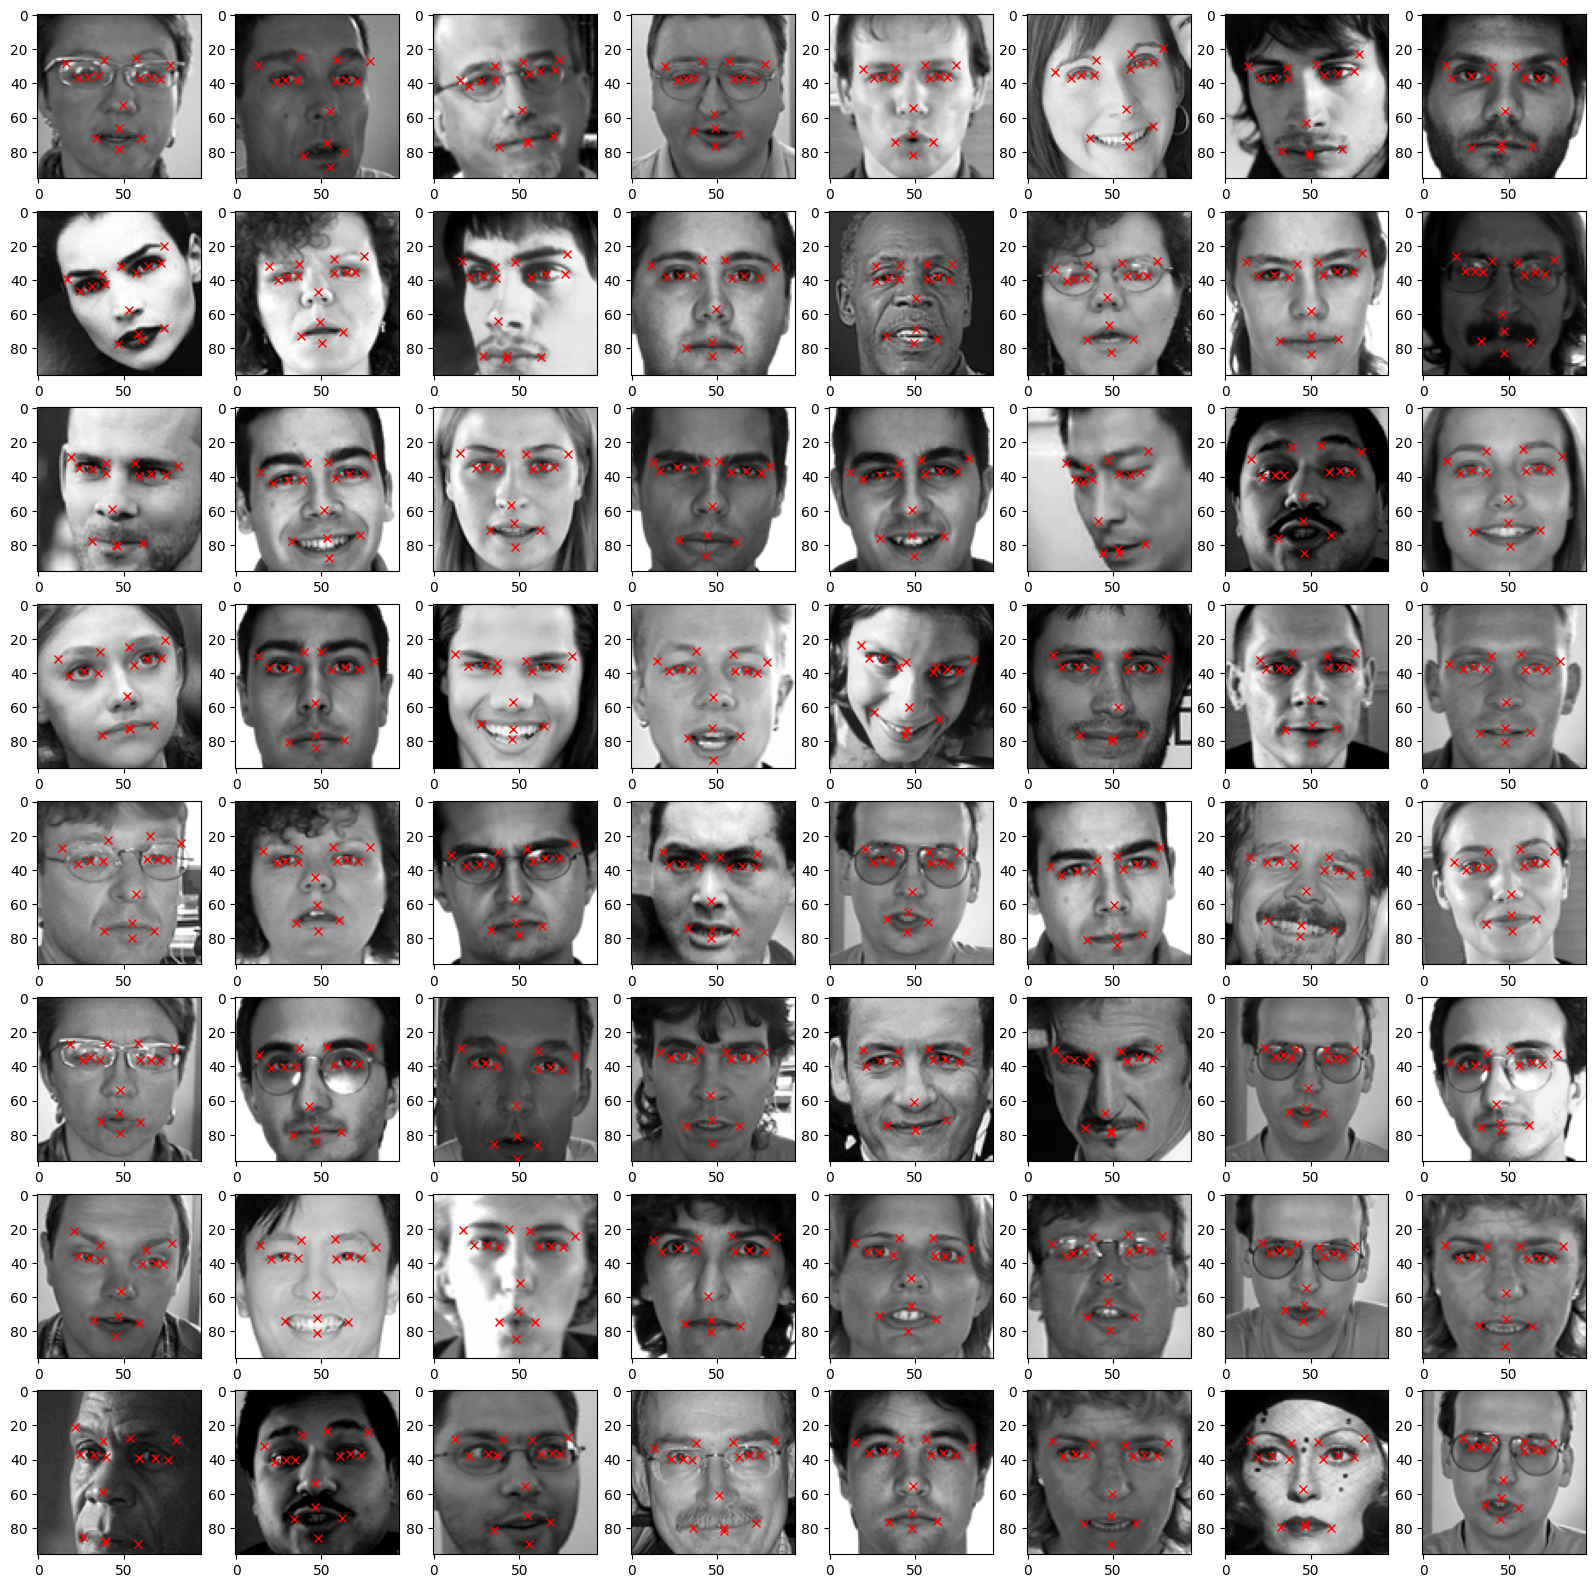

In [122]:
import random

fig = plt.figure(figsize=(20,20))

x = []
while len(x) < 64:
  random_number = np.random.randint(0, len(df))
  if random_number not in x:
    x.append(random_number)

print(x)    # Generated 64 unique random number from data frame

for a in range(64):
  ax = fig.add_subplot(8,8, a+1)        # Here, 8,8 is 8 rows * 8 columns
  a = x[a]
  image = plt.imshow(df['Image'][a], cmap='gray')
  for j in range(1,31,2):
    plt.plot(df.loc[a][j-1], df.loc[a][j], 'rx')

# PERFORM IMAGE AUGMENTATION
Image augmentation is a technique commonly used in deep learning for computer vision tasks, such as image classification, object detection, and segmentation. It involves applying various transformations to the original images in the training dataset to create new training examples.
Some common image augmentation techniques include:

* Rotation: Rotating the image by a certain angle.
* Flip: Flipping the image horizontally or vertically.
* Zoom: Zooming in or out of the image.
* Translation: Shifting the image horizontally or vertically.
* Brightness adjustment: Changing the brightness level of the image.
* Contrast adjustment: Adjusting the contrast of the image.
* Noise injection: Adding random noise to the image.
* Crop and resize: Cropping a portion of the image and resizing it to the original size.
* Shear: Applying shearing transformations to the image.

In [123]:
import copy
copy_df = copy.copy(df)

Generalization of model is very important than memorization. One can't memorise all the thing.

In [124]:
# showing all the key facial point of the dataFrame
columns = copy_df.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

###**Horizontal Flip**

In [125]:
# Fliping image Horizontally
copy_df['Image'] = copy_df['Image'].apply(lambda x:np.flip(x, axis=1))

##since we are fliping Horizonatlly, y co-ordinates values would be the same.
# Only x-coordinates values would change, all we have to do is to substract our initial x-coordinates values form width of the image(96*96)
for i in range(len(columns)):
  if i%2 == 0:          # only even means: x-coordinates
    copy_df[columns[i]] = copy_df[columns[i]].apply(lambda x: 96.0 -float(x))      # 96 pixels -( x-cordinates)value


In [126]:
df['left_eye_center_x']

0       66.033564
1       64.332936
2       65.057053
3       65.225739
4       66.725301
          ...    
2135    67.180378
2136    65.724490
2137    68.430866
2138    64.152180
2139    66.683755
Name: left_eye_center_x, Length: 2140, dtype: float64

In [127]:
# Here value = 96 - df(value)
copy_df['left_eye_center_x']

0       29.966436
1       31.667064
2       30.942947
3       30.774261
4       29.274699
          ...    
2135    28.819622
2136    30.275510
2137    27.569134
2138    31.847820
2139    29.316245
Name: left_eye_center_x, Length: 2140, dtype: float64

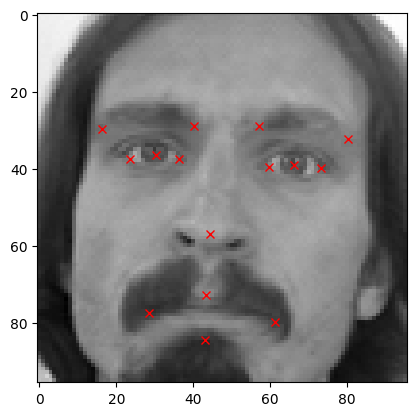

In [128]:
# Showing the original images as:
plt.imshow(df['Image'][0], cmap='gray')
for j in range(1, 31, 2):
  plt.plot(df.loc[0][j-1], df.loc[0][j], 'rx')

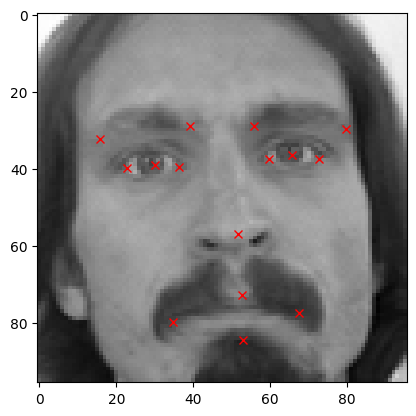

In [129]:
# Showing the Flipped image = Horizontal flipped image
plt.imshow(copy_df['Image'][0], cmap='gray')
for j in range(1, 31, 2):
  plt.plot(copy_df.loc[0][j-1], copy_df.loc[0][j], 'rx')

**Augmented DataFrame** -concate(original + Horizontally flipped data)
* Note: The more we do augmentation, the data become more complicated.


Here we increase the brightness fo this image.

In [130]:
  augmented_df = np.concatenate((df, copy_df))

In [131]:
augmented_df.shape

(4280, 31)

**Brightness: Increase**
* np.clip: "Here CLIP helps to bring pixels values to the range between 0.0 to 255.0, if the pixel values goes out of range.
      * For eg: suppose x=200 pix
        then 200 * 2 = 400 pix which is out of range(0-255). Then np.CLIP bring it between range.

In [132]:
# Randomly increasing the brightness of the image
# We multiply pixel values by random values range(1.5 -2.0) to incease the brightness
# We can clip the value between 0-255
import random

copy_df = copy.copy(df)

In [133]:
copy_df['Image'] = copy_df['Image'].apply(lambda x:np.clip(random.uniform(1.5,2)*x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, copy_df))
augmented_df.shape

(6420, 31)

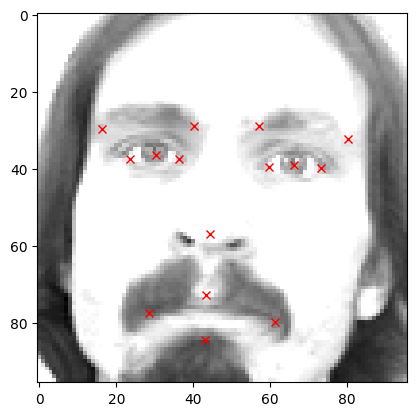

In [134]:
# show the image
plt.imshow(copy_df['Image'][0], cmap='gray')
for j in range(1,31,2):
  plt.plot(copy_df.loc[0][j-1], copy_df.loc[0][j], 'rx')


###**Vertical Flip**
Challenge MINI

In [135]:
ver_df = copy.copy(df)

In [136]:
cloumns = ver_df.columns[:-1]
columns.size

30

In [137]:
#Vertical Flip [axis=0] - flip the image along x-axis
ver_df['Image'] = ver_df['Image'].apply(lambda x: np.flip(x, axis=0))

# Since we are flipping vertically, x-cordinates values would be same
# Only y-cordinates values would changes, all we to do is to substract our initial y-cordinates values from height:96
for i in range(len(columns)):
  if i % 2 == 1:
    ver_df[columns[i]] = ver_df[columns[i]].apply(lambda x: 96.0 -float(x))

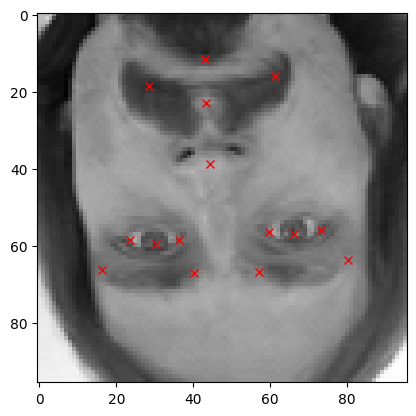

In [138]:
plt.imshow(ver_df['Image'][0], cmap='gray')
#show 'x' red points
for i in range(1, 31, 2):
  plt.plot(ver_df.loc[0][i-1], ver_df.loc[0][i], 'rx')

## PERFORMING DATA NORMALIZATION & taining data
* AUGMENTED Data Frame is in the form of NUMPY Array. So we can't extact images column by
* augmented_df['Image']

In [139]:
# Obtain the value of images which is present in the 31st columns (Since Index start from 0, we refer to 31st column)
img = augmented_df[:, 30]
img

array([array([[238, 236, 237, ..., 250, 250, 250],
              [235, 238, 236, ..., 249, 250, 251],
              [237, 236, 237, ..., 251, 251, 250],
              ...,
              [186, 183, 181, ...,  52,  57,  60],
              [189, 188, 207, ...,  61,  69,  78],
              [191, 184, 184, ...,  70,  75,  90]]),
       array([[219, 215, 204, ...,  92,  88,  84],
              [222, 219, 220, ...,  92,  88,  86],
              [231, 224, 212, ...,  77,  80,  84],
              ...,
              [  1,   1,   1, ...,   1,   1,   1],
              [  1,   1,   1, ...,   1,   1,   1],
              [  1,   1,   1, ...,   1,   1,   1]]),
       array([[144, 142, 159, ..., 208, 207, 207],
              [143, 142, 161, ..., 208, 208, 207],
              [143, 140, 160, ..., 209, 209, 207],
              ...,
              [ 66,  70,  69, ...,  81, 134, 194],
              [ 65,  69,  71, ...,  75,  83, 109],
              [ 65,  68,  70, ...,  78,  78,  77]]), ...,
       array([

**Image Normalization:**
Image normalization is a common preprocessing step in computer vision tasks for several reasons:

1. **Better Model Convergence**: Normalizing pixel values to a fixed range, such as [0, 1] or [-1, 1], can help improve the convergence of optimization algorithms during training. This is because normalizing the input data reduces the scale of input features, which can lead to more stable training dynamics and faster convergence.

2. **Reduced Sensitivity to Scale**: Neural networks can be sensitive to the scale of input features. Normalizing pixel values to a fixed range helps mitigate this sensitivity, making the model more robust to changes in the scale of input data.

3. **Improved Generalization**: Normalizing images can help the model generalize better to unseen data by reducing the impact of variations in pixel intensity across different images. This can lead to better performance on validation and test sets.

4. **Avoiding Saturation**: Neural networks often use activation functions like sigmoid or tanh, which saturate at extreme values. By normalizing pixel values to a fixed range, you can avoid saturation of these activation functions and ensure that gradients flow effectively during training.

5. **Compatibility with Pretrained Models**: Many pretrained models and architectures, especially those trained on large-scale datasets like ImageNet, expect input images to be normalized in a specific way. By normalizing your input images to match the expectations of these models, you can effectively use transfer learning and leverage pretrained weights for your own tasks.

Overall, image normalization is a simple yet effective preprocessing technique that can improve the stability, convergence, and generalization of neural network models in computer vision tasks.

In [140]:
# Normalize the images
img = img / 255       # dividing by highest pixel

# create an empty array of shape (x, 96, 96, 1) to feed the model
img

array([array([[0.93333333, 0.9254902 , 0.92941176, ..., 0.98039216, 0.98039216,
               0.98039216],
              [0.92156863, 0.93333333, 0.9254902 , ..., 0.97647059, 0.98039216,
               0.98431373],
              [0.92941176, 0.9254902 , 0.92941176, ..., 0.98431373, 0.98431373,
               0.98039216],
              ...,
              [0.72941176, 0.71764706, 0.70980392, ..., 0.20392157, 0.22352941,
               0.23529412],
              [0.74117647, 0.7372549 , 0.81176471, ..., 0.23921569, 0.27058824,
               0.30588235],
              [0.74901961, 0.72156863, 0.72156863, ..., 0.2745098 , 0.29411765,
               0.35294118]])                                                   ,
       array([[0.85882353, 0.84313725, 0.8       , ..., 0.36078431, 0.34509804,
               0.32941176],
              [0.87058824, 0.85882353, 0.8627451 , ..., 0.36078431, 0.34509804,
               0.3372549 ],
              [0.90588235, 0.87843137, 0.83137255, ..., 0.301960

In [141]:
# Create an empty array of shape(x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty aray after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i, ] = np.expand_dims(img[i], axis=2)

# Convert the images to float32 to ensure division results in float values
X = np.array(X).astype(np.float32)

In [142]:
X.shape

(6420, 96, 96, 1)

In [143]:
# Obtain the values of x and y co-ordinates which are used as target
y = augmented_df[:, :30]      # excluding 31st column
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [144]:
#X[0][0].shape

**TRAIN & TEST: SPLIT DATA**
* X_test and X_train: INput for testing and training data
* y_test and y_train: Output fo testing and taining data

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
X_train.shape

(5136, 96, 96, 1)

In [147]:
X_test.shape

(1284, 96, 96, 1)

In [148]:
y_test.shape

(1284, 30)

### BUILDING DEEP RESIDUAL NEURAL NETWORK KEY FACIAL POINTS DETECTION MODEL

![alt text](https://drive.google.com/uc?id=1q0If_tsIyz2GfOb9EsRH_8_ue-1QnTlu)

![alt text](https://drive.google.com/uc?id=1GDhehqRRtnTA3-i02cYcalbPA27ej7Ar)

**Creating RES-BLOCK**
* 1. CONVOLUTION BLOCK
* 2. IDENTITY BLOCK
* 3. IDENTITY BLOCK

Let's first create CONVOLUTION BLOCK

In [149]:
def res_block(X, filter, stage):

  ##CONVOLUTION BLOCK
  X_copy = X
  f1, f2, f3 = filter

  #main path ---------------------------------------PART 1
  # 1. Conv2D
  # padding valid : default padding
  X= Conv2D(f1, kernel_size=(1,1), strides=(1,1), name='res_'+str(stage)+'_conv_a', kernel_initializer=glorot_uniform(seed=0))(X)

  #2. MaxPool2D
 # X = MaxPool2D(pool_size=(2,2))(X)

  #3. BatchNorm, Relu
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_conv_a")(X)
  X = Activation('relu')(X)

  #4. Conv2D - kernel(3*3)
  # Padding same : In this type of padding, we only append zero to the left of the array and to the top of the 2D input matrix.
  X = Conv2D(f2, kernel_size=(3,3), strides=(1,1), padding='same', name='res_'+str(stage)+'_conv_b', kernel_initializer=glorot_uniform(seed=0))(X)

  #5. BatchNorm, Relu
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  #6. Conv2D
  X = Conv2D(f3, kernel_size=(1,1), strides=(1,1), name='res_'+str(stage)+'_conv_c', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_c')(X)



  #short path ---------------------------------------PART 2
  #1. Conv2D
  X_copy = Conv2D(f3, (1,1), (1,1), name='res_'+str(stage)+'_conv_copy', kernel_initializer=glorot_uniform(seed=0))(X_copy)

  #2. MaxPool2D
 # X_copy = MaxPool2D(pool_size=(2,2))(X_copy)

  #3. BatchNorm
  X_copy = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADDING BOTH PATH
  X = Add()([X, X_copy])
  X = Activation('relu')(X)



  ##IDENTITY BLOCK 1
  X_copy = X

  #main path
  #1. Conv2D
  X = Conv2D(f1, kernel_size=(1,1), strides=(1,1), name='res_'+str(stage)+'_identity_1_a', kernel_initializer=glorot_uniform(seed =0))(X)

  #2. BatchNorm, relu
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  #3. Conv2D - kernel(3*3)
  X = Conv2D(f2, kernel_size=(3,3), strides=(1,1), padding='same', name='res_'+str(stage)+'_identity_1_b', kernel_initializer=glorot_uniform(seed=0))(X)

  #4. BatchNorm, relu
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  #5. Conv2D
  X = Conv2D(f3, (1,1), (1,1), name='res_'+str(stage)+'_identity_1_c', kernel_initializer=glorot_uniform(seed=0))(X)

  #6. BatchNorm
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_1_c')(X)

  # Add
  X = Add()([X, X_copy])
  X = Activation('relu')(X)


  ##IDENTITY BLOCK 2
  X_copy = X

  #main path
  #1. Conv2D
  X = Conv2D(f1, kernel_size=(1,1), strides=(1,1), name='res_'+str(stage)+'_identity_2_a', kernel_initializer=glorot_uniform(seed=0))(X)
  #2. BatchNorm, relu
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  #3. Conv2D -kernel(3*3)
  X = Conv2D(f2, (3,3), (1,1), padding='same', name='res_'+str(stage)+'_identity_2_b', kernel_initializer=glorot_uniform(seed=0))(X)
  #4. BatchNOrm, relu
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  #5. Conv2D
  X = Conv2D(f3, (1,1), (1,1), name='res_'+str(stage)+'_identity_2_c', kernel_initializer=glorot_uniform(seed=0))(X)
  #6. BatchNorm
  X = BatchNormalization(axis = 3, name='bn_'+str(stage)+'_identity_2_c')(X)

  # Add
  X = Add()([X, X_copy])
  A = Activation('relu')(X)

  return X

![alt text](https://drive.google.com/uc?id=1G_gvfoKJyRGpq_oNejLwDj7ZxIZvCGk6)

### Creating FINAL MODEL

In [150]:
input_shape = (96,96,1)

#1. Input Tensor shape
X_input = Input(input_shape)

#2. ZeroPadding
X = ZeroPadding2D((3,3))(X_input)

#3. Conv2D, BatchNOrm, MaxPool2D
X = Conv2D(64, kernel_size=(7,7), strides=(2,2), name='conv1', kernel_initializer=glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis=3, name= 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides=(2,2))(X)

#4. RES_BLOCK
X = res_block(X, filter=[64, 64, 256], stage=2)
X = res_block(X, filter= [128, 128, 512], stage=3)
X = res_block(X, filter= [256,256,1024], stage= 4)

#5. AveragePooling2D
X = AveragePooling2D((2,2), name='Average_Pooling')(X)

#6. Final Layer(Flatten(), [Dense Layer-Relu, Dropout]*2, Dense Layer-Relu)
X =Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)

X = Dense(2048, activation='relu')(X)
X = Dropout(0.1)(X)

X = Dense(30, activation = 'relu')(X)



model_1_facialKeyPoints = Model(inputs = X_input, outputs=X)
model_1_facialKeyPoints.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 520,902,174
Trainable params: 520,882,334
Non-trainable params: 19,840
__________________________________________________________________________________________________


In [151]:
model_1_facialKeyPoints.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 520,902,174
Trainable params: 520,882,334
Non-trainable params: 19,840
__________________________________________________________________________________________________


### COMPLIE & TRAIN KEY FACIAL POINTS DETECTION deep learning model

* adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    name='adam'
  )

In [162]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['accuracy'])

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x782c76059ba0>

In [164]:
model_1_facialKeyPoints.compile(optimizer= 'adam' , loss= keras.losses.binary_crossentropy, metrics=['accuracy'])